### Deep Learning A-Z exploration in Python

> The story: A bank is investigating a very high rate of customer leaving the bank. Here is a 10.000 records dataset to investigate and predict which of the customers are more likely to leave the bank soon.

### Summary

1. Introduction and data exploration
2. Feature Engineering
3. Model train (k-Fold cross validation)


In [1]:
# Useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

### 1. Introduction

In [2]:
# Read the dataset and print the columns info
bank_df = pd.read_csv('data/Churn_Modelling.csv')
bank_df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [3]:
# Check what countries are in the dataset (Create dummy variables in section 2)
bank_df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [4]:
# Check possible family members in the dataset
# There are a lot of Surnames duplicated, but for now let's ignore this.
print("Number of repeated Surnames: %s of 10000" % sum(bank_df['Surname'].duplicated()))

Number of repeated Surnames: 7068 of 10000


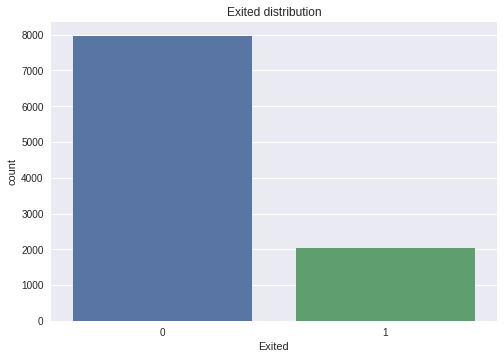

In [5]:
# Check if the dataset is balanced (Spoiler: it isn't. Life is not that easy)
ax = plt.axes()
sns.countplot(x='Exited', data=bank_df, ax=ax);
ax.set_title('Exited distribution')
plt.show()

In [6]:
# Check if there are some null values in the dataset
bank_df.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

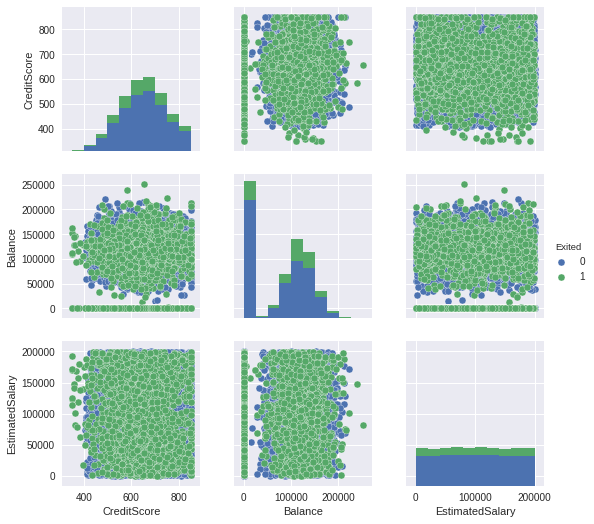

In [7]:
# Pair plot of some interesting variables
# The variables that I thought it should be most impacting
sns.pairplot(bank_df, vars=['CreditScore', 'Balance', 'EstimatedSalary'], hue='Exited')
plt.show()

### 2. Feature Engineering

In [8]:
# Binarization of the Geographic information
# Get this piece of code from this awesome notebook (https://www.kaggle.com/khozzy/kobe-shots-show-me-your-best-model)
dummies = pd.get_dummies(bank_df['Geography'])
dummies = dummies.add_prefix("{}#".format('Geography'))
bank_df.drop('Geography', axis=1, inplace=True)
bank_df = bank_df.join(dummies)

In [9]:
# Remove unuseful columns
bank_df.drop('RowNumber', axis=1, inplace=True)
bank_df.drop('CustomerId', axis=1, inplace=True)
bank_df.drop('Surname', axis=1, inplace=True)

# Binary values for Gender
# There are only 2 genres on this dataset and they are balanced
bank_df['Gender'].replace("Female",0,inplace= True)
bank_df['Gender'].replace("Male",1,inplace= True)
bank_df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography#France,Geography#Germany,Geography#Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [10]:
# Describing some variables and choose what to normalize
bank_df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography#France,Geography#Germany,Geography#Spain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000


In [11]:
# Normalizing Balance and EstimatedSalary
keys = ['Balance', 'EstimatedSalary']
for x in keys:
    max_x = max(bank_df[x])
    min_x = min(bank_df[x])
    bank_df[x] = (bank_df[x] - min_x)/(max_x - min_x)
bank_df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography#France,Geography#Germany,Geography#Spain
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,0.304848,1.530200,0.70550,0.515100,0.500441,0.203700,0.501400,0.250900,0.247700
std,96.653299,0.497932,10.487806,2.892174,0.248696,0.581654,0.45584,0.499797,0.287580,0.402769,0.500023,0.433553,0.431698
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,0.254977,0.000000,0.000000,0.000000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,0.387402,1.000000,1.00000,1.000000,0.500960,0.000000,1.000000,0.000000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,0.508749,2.000000,1.00000,1.000000,0.746955,0.000000,1.000000,1.000000,0.000000
max,850.000000,1.000000,92.000000,10.000000,1.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Model train (k-Fold)

In [12]:
# Separate the df from labels to classify
X = bank_df.drop('Exited', axis=1).as_matrix()
y = bank_df['Exited'].as_matrix()
print(X.shape)
print(y.shape)

(10000, 12)
(10000,)


In [13]:
# Setup the k-fold cross validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle = True)

In [14]:
# Try random forest first
accuracy = 0
cm = 0
prfs = 0

for train_idx, test_idx in kf.split(X):
    # Separe training and test in the Training set for k-Fold
    fold_Xtrain, fold_Xtest = X[train_idx], X[test_idx]
    fold_ytrain, fold_ytest = y[train_idx], y[test_idx]
      
    # Train
    clf = RandomForestClassifier(n_jobs = -1, n_estimators = 200, criterion = "entropy")
    clf.fit(fold_Xtrain, fold_ytrain)
    pred = clf.predict(fold_Xtest)
    accuracy += accuracy_score(fold_ytest, pred)*100
    cm += confusion_matrix(fold_ytest, pred)
    prfs += np.asarray(precision_recall_fscore_support(fold_ytest, pred))*100
    
print("Average statistics: ")
print("")
print("Accuracy = %s%%" % '{0:.2f}'.format(accuracy/k_folds))
print("Precision = No: %s%% , Yes: %s%%" % ('{0:.2f}'.format(prfs[0,0]/k_folds), '{0:.2f}'.format(prfs[0,1]/k_folds)))
print("Recall = No: %s%% , Yes: %s%%" % ('{0:.2f}'.format(prfs[1,0]/k_folds), '{0:.2f}'.format(prfs[1,1]/k_folds)))
print("F1-score = No: %s%% , Yes: %s%%" % ('{0:.2f}'.format(prfs[2,0]/k_folds), '{0:.2f}'.format(prfs[2,1]/k_folds)))
print("")
print("Confusion-Matrix: ")
print(cm)

Average statistics: 

Accuracy = 86.39%
Precision = No: 87.75% , Yes: 76.97%
Recall = No: 96.36% , Yes: 47.52%
F1-score = No: 91.85% , Yes: 58.70%

Confusion-Matrix: 
[[7673  290]
 [1071  966]]
